# Create Project

In [28]:
#import libraries 
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer


## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Global importance tools
import joblib
import shap
from sklearn.inspection import permutation_importance
# ## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
plt.style.use(('ggplot','tableau-colorblind10'))

## Functions

In [29]:
def evaluate_regression(model, X_train,y_train, X_test, y_test,for_slides=True): 
    """Evaluates a scikit learn regression model using r-squared and RMSE
    FOR SLIDES VERS DOES MULTIPLE PRINT STATEMENTS FOR VERTICAL DISPLAY OF INFO"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
    

    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
    
    if for_slides:
        df_version =[['Split','R^2','MAE','RMSE']]
        df_version.append(['Train',r2_train, mae_train, rmse_train])
        df_version.append(['Test',r2_test, mae_test, rmse_test])
        df_results = pd.DataFrame(df_version[1:], columns=df_version[0])
        df_results = df_results.round(2)
        display(df_results.style.hide(axis='index').format(precision=2, thousands=','))
        
    else: 
        print(f"Training Data:\tR^2 = {r2_train:,.2f}\tRMSE = {rmse_train:,.2f}\tMAE = {mae_train:,.2f}")
        print(f"Test Data:\tR^2 = {r2_test:,.2f}\tRMSE = {rmse_test:,.2f}\tMAE = {mae_test:,.2f}")

def get_coefficients(lin_reg):
    coeffs = pd.Series(lin_reg.coef_, index= lin_reg.feature_names_in_)
    coeffs.loc['intercept'] = lin_reg.intercept_
    return coeffs

def plot_coefficients(coeffs, sort_values=True, top_n=None, figsize=(6,4),
                     title="Linear Regression Coefficients", xlabel='Coefficient'):
    """Plots a Series of coefficients as horizotal bar chart, with option to sort
    and to only keep top_n coefficients"""
        
    if top_n is not None:
        top_n = coeffs.abs().rank().sort_values(ascending=False).head(top_n)
        coeffs = coeffs.loc[top_n.index]
        
    if sort_values:
        coeffs = coeffs.sort_values()

        
        
    ax = coeffs.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax


def get_importances(rf_reg):
    importances = pd.Series(rf_reg.feature_importances_, index= rf_reg.feature_names_in_)
    return importances


def plot_importances(importances, sort_values=True, top_n=None, figsize=(6,4),
                     title="Feature Importance", xlabel='Importance'):
    if sort_values:
        importances = importances.sort_values()
        
    if top_n is not None:
        importances = importances.tail(top_n)
        
        
    ax = importances.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax

## Load the Joblib Files

In [30]:
# load the joblib file
loaded_joblib= joblib.load('best-models2.joblib')
loaded_joblib.keys()


dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'preprocessor', 'LinearRegression', 'RandomForestRegressor'])

In [31]:
# save the objects
X_train = loaded_joblib['X_train']
y_train = loaded_joblib['y_train']
X_test = loaded_joblib['X_test']
y_test = loaded_joblib['y_test']
preprocessor = loaded_joblib['preprocessor']
lin_reg = loaded_joblib['LinearRegression']
rf_reg = loaded_joblib['RandomForestRegressor']

In [32]:
## Get feature names from already-fit preprocessor
feature_names = preprocessor.get_feature_names_out()


## Use the preprocessor to transform X_train and X_test
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          index=X_train.index,
                          columns=feature_names)

X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                         index=X_test.index,
                          columns=feature_names)
X_train_df.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,...,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2
3527,7.86,0.00,38.38,"1,997.00",0.00,1.00,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00
7331,19.75,0.01,188.09,"2,009.00",1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00
4003,10.20,0.00,114.09,"1,997.00",1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00
2737,6.48,0.03,146.91,"1,997.00",1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00
3553,15.00,0.05,122.84,"1,997.00",1.00,0.00,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00


## Linear Regression

In [33]:
## Use our evaluate_regression function to evalaute the linear regression
evaluate_regression(lin_reg, X_train_df, y_train, X_test_df, y_test)

Split,R^2,MAE,RMSE
Train,0.47,810.33,"1,091.18"
Test,0.47,785.24,"1,080.82"


In [34]:
## Setting float format for readability
pd.set_option('display.float_format',lambda x: f"{x:,.2f}")

In [35]:
## Get the coefficients from the lin reg
coeffs = get_coefficients(lin_reg)
coeffs

Item_Weight                         -4.04
Item_Visibility                   -717.31
Item_MRP                            16.36
Outlet_Establishment_Year            0.02
Item_Fat_Content_Low Fat           -11.38
Item_Fat_Content_Regular            12.13
Item_Type_Baking Goods              -5.53
Item_Type_Breads                   134.46
Item_Type_Breakfast                -15.19
Item_Type_Canned                    -5.88
Item_Type_Dairy                    -69.68
Item_Type_Frozen Foods             -66.65
Item_Type_Fruits and Vegetables    -65.95
Item_Type_Hard Drinks             -124.83
Item_Type_Health and Hygiene       -18.89
Item_Type_Household                -71.59
Item_Type_Meat                     -23.40
Item_Type_Others                   -22.88
Item_Type_Seafood                  349.65
Item_Type_Snack Foods              -42.15
Item_Type_Soft Drinks              -88.43
Item_Type_Starchy Foods            137.70
Outlet_Size_High                    62.18
Outlet_Size_Medium                

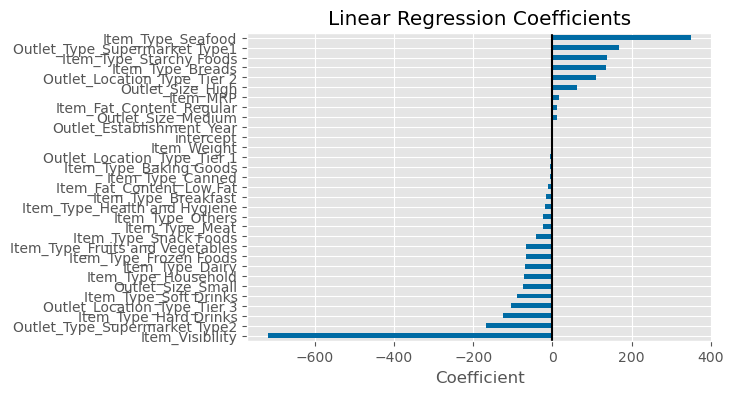

<AxesSubplot: title={'center': 'Linear Regression Coefficients'}, xlabel='Coefficient'>

In [36]:
## plot the coefficients
plot_coefficients(coeffs)

# Explain Random Forest Using SHAP

Split,R^2,MAE,RMSE
Train,0.92,317.62,436.52
Test,0.38,844.42,"1,163.80"


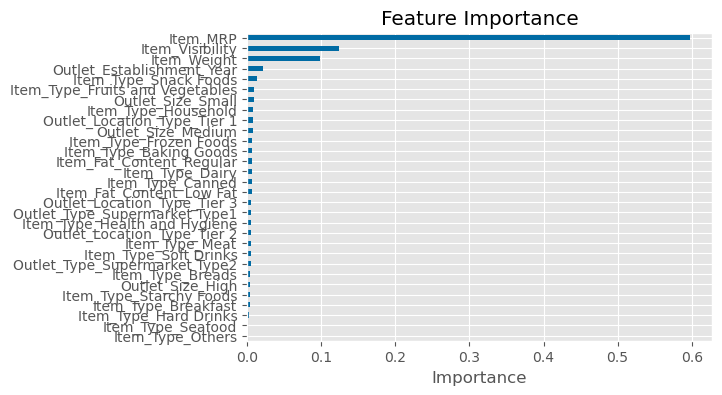

<AxesSubplot: title={'center': 'Feature Importance'}, xlabel='Importance'>

In [41]:
## evaluate the random forest
evaluate_regression(rf_reg,X_train_df,y_train, X_test_df, y_test)

## extract the plot the feature importances
importances = get_importances(rf_reg)
plot_importances(importances)

## Permutation importance

In [42]:
## run performatation_importance on the rf  using the test data and random_state=SEED
result = permutation_importance(rf_reg, X_test_df, y_test,scoring='r2',
                                n_jobs=-1,random_state=SEED)
result.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [43]:
## save the average importances as a Series
perm_importances = pd.Series(result['importances_mean'], index=rf_reg.feature_names_in_)
perm_importances

Item_Weight                       -0.02
Item_Visibility                   -0.03
Item_MRP                           0.88
Outlet_Establishment_Year         -0.01
Item_Fat_Content_Low Fat          -0.00
Item_Fat_Content_Regular          -0.00
Item_Type_Baking Goods            -0.00
Item_Type_Breads                  -0.00
Item_Type_Breakfast                0.00
Item_Type_Canned                  -0.00
Item_Type_Dairy                   -0.00
Item_Type_Frozen Foods            -0.00
Item_Type_Fruits and Vegetables   -0.01
Item_Type_Hard Drinks              0.00
Item_Type_Health and Hygiene      -0.00
Item_Type_Household                0.00
Item_Type_Meat                    -0.00
Item_Type_Others                  -0.00
Item_Type_Seafood                  0.00
Item_Type_Snack Foods             -0.00
Item_Type_Soft Drinks              0.00
Item_Type_Starchy Foods           -0.00
Outlet_Size_High                   0.00
Outlet_Size_Medium                -0.00
Outlet_Size_Small                  0.00


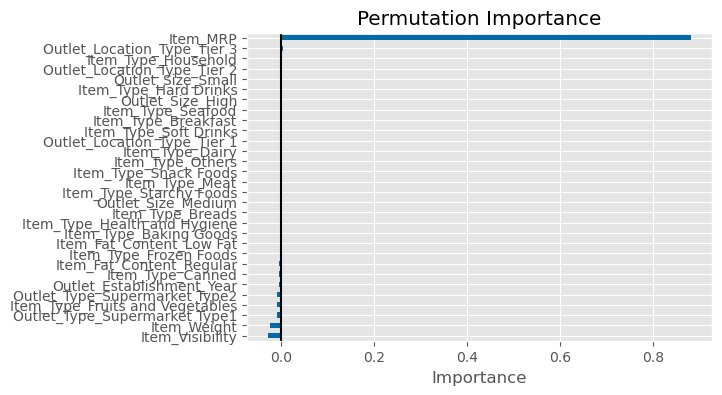

<AxesSubplot: title={'center': 'Permutation Importance'}, xlabel='Importance'>

In [44]:
# Use our plot_importances function, but change title to "Permutation Importance"
plot_importances(perm_importances,title='Permutation Importance')

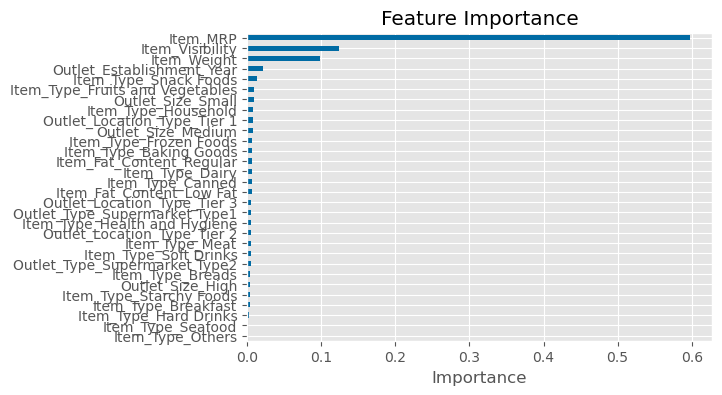

<AxesSubplot: title={'center': 'Feature Importance'}, xlabel='Importance'>

In [45]:
# Compare to the random forst feature importance
plot_importances(importances)

## Linear Regression with Permutation Importance

In [46]:
## run performatation_importance on the lin_reg  using the test data and random_state=SEED
results_linreg = permutation_importance(lin_reg, X_test_df, y_test,scoring='r2', n_repeats=3,
                                n_jobs=-1,random_state=SEED)
result.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

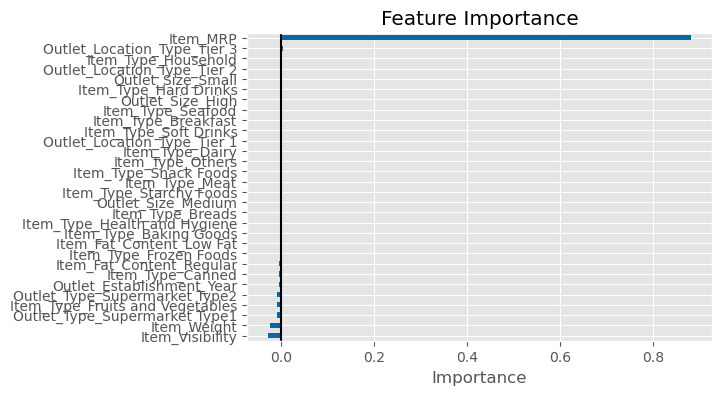

<AxesSubplot: title={'center': 'Feature Importance'}, xlabel='Importance'>

In [47]:
## Make into a series called perm_importances_linreg
perm_importances_linreg = pd.Series(result['importances_mean'], 
                                    index=lin_reg.feature_names_in_)

plot_importances(perm_importances_linreg)

# Global Explanations

In [48]:
# initialize javascript:
shap.initjs()


In [49]:
# create X shap
X_shap = shap.sample(X_test,nsamples=400,random_state=321)
X_shap

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
14,16.35,Low Fat,0.07,Fruits and Vegetables,196.44,1987,High,Tier 3,Supermarket Type1
1493,7.11,Low Fat,0.04,Household,59.26,2009,Medium,Tier 3,Supermarket Type2
190,10.30,Low Fat,0.15,Meat,103.96,1999,Medium,Tier 1,Supermarket Type1
6863,19.35,Regular,0.04,Soft Drinks,165.09,1999,Medium,Tier 1,Supermarket Type1
8462,5.79,Regular,0.05,Fruits and Vegetables,85.99,1987,High,Tier 3,Supermarket Type1
...,...,...,...,...,...,...,...,...,...
4828,8.84,Regular,0.08,Frozen Foods,109.92,2009,Medium,Tier 3,Supermarket Type2
149,7.24,Low Fat,0.08,Household,117.55,2004,Small,Tier 2,Supermarket Type1
2856,20.20,Regular,0.04,Breakfast,157.66,1997,Small,Tier 1,Supermarket Type1
7946,8.60,Regular,0.04,Canned,188.55,1987,High,Tier 3,Supermarket Type1


In [50]:
## get the corresponding y-values
y_shap = y_test.loc[X_shap.index]
y_shap 

14     1,977.43
1493     651.82
190    1,661.84
6863     982.72
8462   1,494.06
         ...   
4828   1,547.32
149    1,969.44
2856   1,095.24
7946   3,795.06
4922   2,326.97
Name: Item_Outlet_Sales, Length: 400, dtype: float64

## Explainer

In [51]:
# random forest explainer
explainer = shap.Explainer(rf_reg)
explainer

In [53]:
## Setting float format for readability
pd.set_option('display.float_format',lambda x: f"{x:,.2f}")

In [54]:
## Get shap values from the explainer
shap_values = explainer(X_shap,y_shap)

ValueError: could not convert string to float: 'Low Fat'

#  Explainer 2

In [55]:
# Take a sample of the training data (nsampel=500, use random_state=SEED)
X_shap2 = shap.sample(X_train_df, nsamples = 100,random_state=SEED)
X_shap2.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,...,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2
6516,8.51,0.02,192.15,"2,009.00",1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00
6981,13.10,0.08,168.12,"2,004.00",1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00
2634,11.80,0.11,220.38,"2,004.00",0.00,1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00
6508,17.10,0.05,83.56,"2,004.00",1.00,0.00,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00
2048,10.50,0.04,40.12,"2,004.00",1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00


In [56]:
## get the corresponding y-values
y_shap2 = y_train.loc[X_shap2.index]
y_shap2

6516   1,937.48
6981   2,005.39
2634   4,447.54
6508   1,860.25
2048     849.56
         ...   
6981   2,005.39
8420   1,867.57
2579   1,584.60
8264   3,705.18
4114     309.60
Name: Item_Outlet_Sales, Length: 100, dtype: float64

In [58]:
#get the shape
X_shap2.shape

(100, 30)

In [59]:
explainer =shap.TreeExplainer(rf_reg)
shap_values2 = explainer.shap_values(X_shap2,y_shap,check_additivity=False)

## Plot 2

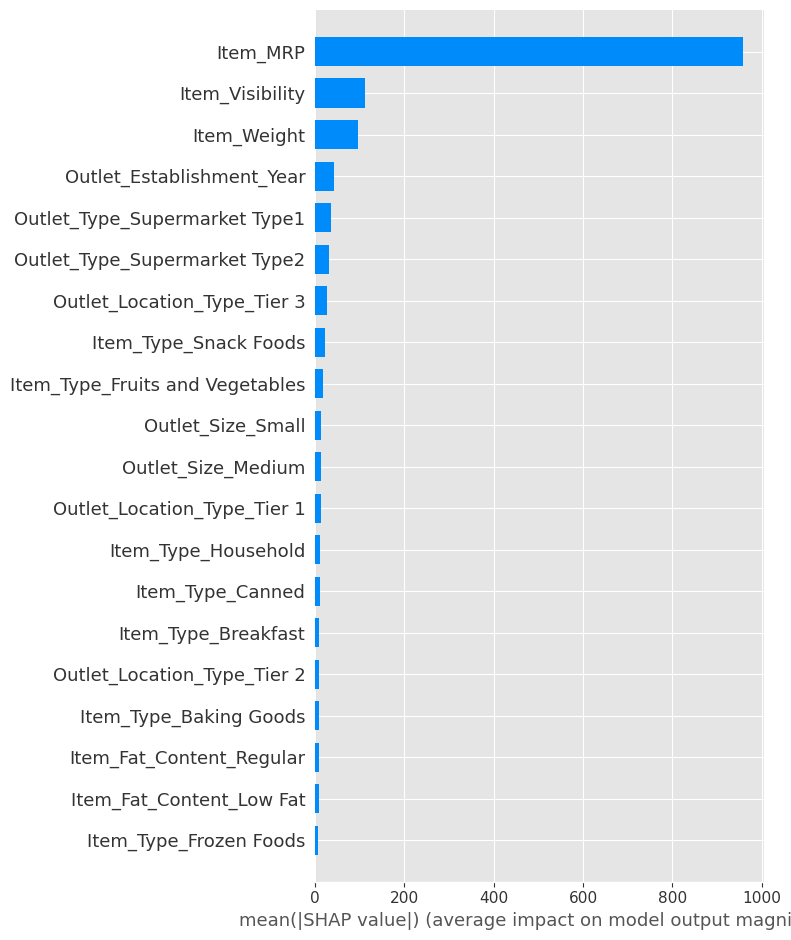

In [61]:
## create a summary plot (bar version)
shap.summary_plot(shap_values2, features = X_shap2, plot_type='bar')

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


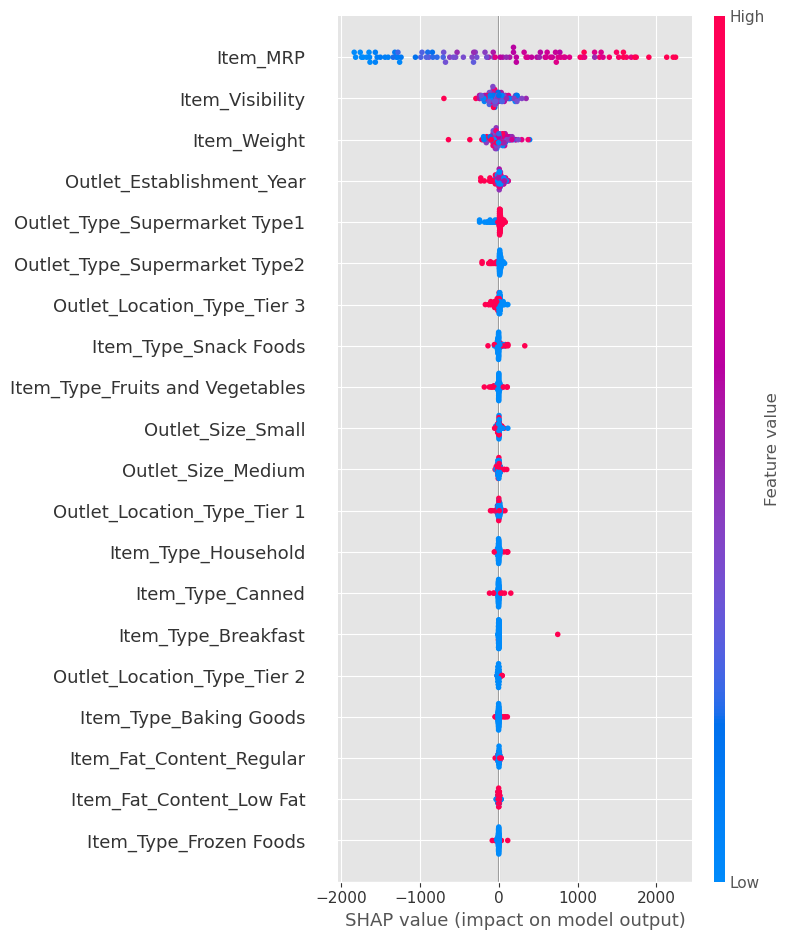

In [62]:
## create a summary plot (dot/default version)
shap.summary_plot(shap_values2, features = X_shap2)

# Previous Code and Junk

# Plot

# Linear Regression

## Plot coefficients with function

### Three most impactful coefficients:
- Outlet size: the size of the outlet affect grocery sales
- Outlet identifier- this is a not useful index
- Outlet type: similar to size but  differences between a grocery store and an outlet

# Random Forest Model